# TP3 - *Latent Dirichlet Allocation* et Inférence variationnelle 

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse à la méthode "inférence variationnelle" (VI) qui permet d'approcher la loi a posteriori d'un modèle (généralement inconnue) par une autre loi plus simple (généralement un produit de lois bien connues). Nous allons l'appliquer à un modèle probabiliste pour des données textuelles, appelé *Latent Dirichlet Allocation* (LDA, qui n'a rien à voir avec la LDA *Linear Discriminant Analysis* du cours de ML).

### Instructions

1. Renommer votre notebook sous la forme `tp3_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 23 Décembre 2023, 23h59.

In [332]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

### Partie 0 - Introduction

LDA is a popular probabilistic model for text data, introducted in [Blei et al. (2003)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). In this model, the posterior distribution is intractable, and we choose to resort to variational inference (note that a Gibbs sampler would be feasible as well, but would be very slow). In particular, the CAVI updates can be easily derived.

In a few words, in LDA, each document is a mixture of topics, and each topic is a mixture of words. Uncovering those is the goal of *topic modeling*, and this is what we are going to do today. We will be using a collection of abstracts of papers published in JMLR (*Journal of Machine Learning Research*), one of the most prominent journals of the field.

**Check the .pdf file describing the model.**
The posterior is :
$$p(\boldsymbol{\beta}, \boldsymbol{\theta}, \mathbf{z} | \mathcal{D}),$$
which we are going to approximate in the following way :
$$\simeq \left[ \prod_{k=1}^K q(\beta_k) \right] \left[ \prod_{d=1}^D q(\theta_d) \right] \left[ \prod_{d=1}^D \prod_{n=1}^{N_d} q(z_{dn}) \right], $$
with :
* $q(\beta_k)$ a Dirichlet distribution (of size V) with parameter $[\lambda_{k1}, ...,\lambda_{kV}]$
* $q(\gamma_d)$ a Dirichlet distribution (of size K) with parameter $[\gamma_{d1}, ...,\gamma_{dK}]$
* $q(z_{dn})$ a Multinomial distribution (of size K) with parameter $[\phi_{dn1}, ..., \phi_{dnK}]$

The updates are as follows :
* $$\lambda_{kv} = \eta + \sum_{d=1}^D \sum_{n=1}^{N_d} w_{dnv} \phi_{dnk} $$
* $$\gamma_{dk} = \alpha + \sum_{n=1}^{N_d} \phi_{dnk}$$
* $$ \phi_{dnk} \propto \exp \left( \Psi(\gamma_{dk}) + \Psi(\lambda_{k, w_{dn}}) - \Psi(\sum_{v=1}^V \lambda_{kv}) \right)$$

$\Psi$ is the digamma function, use `scipy.special.digamma`.

### Partie 1 - Les données

The data is already prepared, see code below. We have a total of 1898 abstracts.

In [333]:
jmlr_papers = pkl.load(open("jmlr.pkl","rb"))

**Q1.** Fill in a list of keywords from the course, to see how many papers are about probabilistic ML.

In [334]:
bayesian_jmlr_papers = []

for paper in jmlr_papers:
    bayesian_keywords = ["MCMC","Sampling","Bayesian","inference","Markov","Monte Carlo","Gibs",
                         "prior","posterior","likelihood","conjugate"]
    if any([kwd in paper["abstract"] for kwd in bayesian_keywords]):
        bayesian_jmlr_papers.append(paper)
        
print("There are", str(len(bayesian_jmlr_papers))+" Bayesian papers out of", str(len(jmlr_papers)))

There are 596 Bayesian papers out of 1898


Let us now preprocess the data. It is important to remove so-called "stop-words" like a, is, but, the, of, have... Scikit-learn will do the job for us. We will keep only the top-1000 words from the abstracts.

As a result, we get the count matrix $\mathbf{C}$ of size $D = 1898 \times V = 1000$. $c_{dv}$ is the number of occurrences of word $v$ in document $d$. This compact representation is called "bag-of-words". Of course from $\mathbf{C}$ you easily recover the words, since in LDA the order does not matter.

In [335]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1000, stop_words='english')
X = vectorizer.fit_transform([paper["abstract"] for paper in jmlr_papers])
print(vectorizer.get_feature_names_out()) # Top-1000 words
C = X.toarray() # Count matrix

# Removing documents with 0 words
idx = np.where(np.sum(C, axis = 1)==0)
C = np.delete(C, idx, axis = 0)

['100' '16' '17' '18' '949' '_blank' 'ability' 'able' 'abs' 'according'
 'account' 'accuracy' 'accurate' 'achieve' 'achieved' 'achieves' 'action'
 'actions' 'active' 'adaboost' 'adaptive' 'addition' 'additional'
 'additive' 'address' 'advantage' 'advantages' 'agent' 'aggregation' 'al'
 'algorithm' 'algorithmic' 'algorithms' 'allow' 'allowing' 'allows'
 'alternative' 'analysis' 'analyze' 'applicable' 'application'
 'applications' 'applied' 'apply' 'applying' 'approach' 'approaches'
 'appropriate' 'approximate' 'approximately' 'approximation'
 'approximations' 'arbitrary' 'art' 'article' 'artificial' 'associated'
 'assume' 'assumed' 'assumption' 'assumptions' 'asymptotic'
 'asymptotically' 'attributes' 'available' 'average' 'averaging' 'bandit'
 'base' 'based' 'basic' 'basis' 'batch' 'bayes' 'bayesian' 'behavior'
 'belief' 'benchmark' 'best' 'better' 'bias' 'bib' 'binary' 'block'
 'boosting' 'bound' 'bounded' 'bounds' 'br' 'build' 'building' 'called'
 'capture' 'carlo' 'case' 'cases' 'ca

**Q2.** How many elements of $\mathbf{C}$ are non-zero ? Is this surprising ?

In [319]:
nb_elements_non_zero = np.sum(C>0)/np.sum(C>=0)
print("There are", str(nb_elements_non_zero.round(4)*100)+"% of non-zero elements in the count matrix")

There are 4.53% of non-zero elements in the count matrix


__Remarque__: Ce résultats n'est pas surprenant car les abstracts sont des textes courts donc il y a peu de mots différents dans chaque abstracts surtout qu'on considère que les 1000 mots les plus fréquents.

### Partie 2 - Inférence variationnelle

As you know from the lecture, VI aims at maximizing the ELBO. I have prepared for you the function to compute the ELBO.

In [320]:
from scipy.special import digamma, loggamma

def ELBO(L, G, phi, a, e, W):
    # Computes the ELBO with the values of the parameters L (Lambda), G (Gamma), and Phi
    # a, e are hyperparameters (alpha and eta)
    # W are the words (obsereved)
    
    # L - K x V matrix (variational parameters Lambda)
    # G - D x K matrix (variational parameters Gamma)
    # phi - List of D elements, each element is a Nd x K matrix (variational parameters Phi)
    # a - Scalar > 0 (hyperparameter alpha)
    # e - Scalar > 0 (hyperparameter eta)
    # W - List of D elements, each element is a Nd x V matrix (observed words)
    
    e_log_B = (digamma(L).T - digamma(np.sum(L, axis = 1))).T
    e_log_T = (digamma(G).T - digamma(np.sum(G, axis = 1))).T
    K = L.shape[0]
    D = G.shape[0]
    V = L.shape[1]
    t1 = (e-1)*np.sum(e_log_B)
    t2 = (a-1)*np.sum(e_log_T)

    phi_s = np.zeros((D,K))
    for d in range(0,D):
        phi_s[d,:] = np.sum(phi[d], axis = 0)
    t3 = np.sum(e_log_T*phi_s)
    
    tmp = np.zeros((K,V))
    for d in range(0,D):
        tmp = tmp + np.dot(phi[d].T, W[d])
    t4 = np.sum(e_log_B*tmp)
    
    t5 = np.sum(loggamma(np.sum(L, axis = 1))) - np.sum(loggamma(L)) + np.sum((L-1)*e_log_B)
    t6 = np.sum(loggamma(np.sum(G, axis = 1))) - np.sum(loggamma(G)) + np.sum((G-1)*e_log_T)

    t7 = 0
    for d in range(0,D):
        t7 = t7 + np.sum(phi[d]*np.log(phi[d] + np.spacing(1)))

    return t1 + t2 + t3 + t4 - t5 - t6 - t7

**Q1.** Transform the matrix $\mathbf{C}$ into the observed words $\mathbf{w}$. $\mathbf{w}$ should be a list of $D$ elements, each element of the list being a $N_d \times V$ matrix.

In [321]:
def get_w(c):
    Nd = np.sum(c > 0)
    w = np.zeros((Nd, 1000))
    idx = np.where(c > 0)[0] 
    # parcours des colonnes de w
    j = 0
    for i in range(len(idx)):
        # met 1 sur les lignes de j jusqu'à j+c[idx[i]] et colonne idx[i]
        w[j:j + c[idx[i]], idx[i]] = 1
        j = j + c[idx[i]]
    return w

result = get_w(C[0])
print(np.sum(result, axis = 1))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [322]:
D = C.shape[0] # Number of documents
V = C.shape[1] # Number of words
#Nd_max = np.max(np.sum(C, axis = 1)) # Maximum number of words in a document
#print("There are", str(D)+" documents,", str(V)+" words and", str(Nd_max)+" maximum words in a document")
W  = []
for d in range(0,D):
    W.append(get_w(C[d]))

**Q2.** Implement the CAVI algorithm. The updates are given at the beginning of the notebook. Monitor the convergence with the values of the ELBO (but start with a fixed number of iterations, like 50).

In [323]:
W_d_n = np.zeros((D, np.max([W[d].shape[0] for d in range(D)])))
for d in range(D):
    for n in range(W[d].shape[0]):
            W_d_n[d,n] = np.where(W[d][n] == 1)[0][0]

# entier
W_d_n = W_d_n.astype(int)

In [324]:
# import diagmma
from scipy.special import digamma
from tqdm import tqdm
def CAVI(W, K, a, e, seed): # Other arguments may be added
    np.random.seed(seed)
    """
    Args:
        W (_type_):  taille D * Nd * V
        K (_type_): nombre de topics
        a (_type_): hyperparamètre alpha
        e (_type_): hyperparamètre eta

    Returns:
        L  : K * V ; valuer des lambda_kv
        G : D * K; valeur des gamma_dk
        phi : D * Nd * K; valeur des phi_dnk
        
    """
    # Initialization
    D = len(W)
    V = W[0].shape[1]
 
    L = np.random.gamma(100, 1/100, (K, V))
    G =  np.random.gamma(100, 1/100, (D, K))
    phi = [np.ones((W[d].shape[0], K)) for d in range(D)]
     
    ELBO_value = []
    
    # Iterations
    while len(ELBO_value) < 2 or np.abs(ELBO_value[-1] - ELBO_value[-2])/np.abs(ELBO_value[-2]) > 1e-4:
        # update phi
        e_log_B = (digamma(L).T - digamma(np.sum(L, axis = 1))).T
        e_log_T = (digamma(G).T - digamma(np.sum(G, axis = 1))).T
        for d in range(D):
            for n in range(W[d].shape[0]):
                phi[d][n] = np.exp(e_log_B[:,W_d_n[d,n]] + e_log_T[d])
                phi[d][n] = phi[d][n]/np.sum(phi[d][n])
              
                
        # update lambda et gamma
        L = np.zeros((K, V))
        for d in range(0,D):
            L += np.dot(phi[d].T, W[d])
            G[d] = np.sum(phi[d], axis = 0)
        L = e + L
        G = a + G
        
        
        
        ELBO_value.append(ELBO(L, G, phi, a, e, W))
        
    return L, G, phi, ELBO_value

**Q3.** Run the algorithm with $K = 10$, $\alpha = 0.5$, $\eta = 0.1$. From the results, compute the MMSE of $\lambda_{kv}$ and $\gamma_{dk}$.

**Bonus** : Re-run the algorithm several times with different initializations, and keep the solution which returns the highest ELBO.

NB : In my implementation, one iteration of the CAVI algorithm takes about 4 seconds to run.

In [343]:
L1, G1, phi1, ELBO_value1 = CAVI(W, 10, 0.5, 0.1, 2)
L2, G2, phi2, ELBO_value2 = CAVI(W, 10, 0.2, 0.3, 2) # meme initialisations mais hyperparametre different
L2, G3, phi3, ELBO_value3 = CAVI(W, 10, 0.1, 0.5, 8)


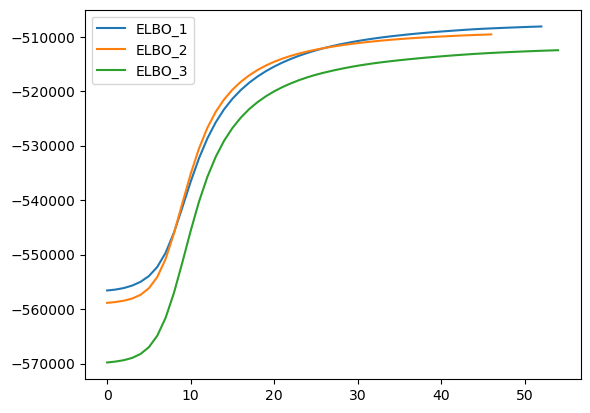

In [344]:
plt.plot(ELBO_value1,label = "ELBO_1")
plt.plot(ELBO_value2, label = "ELBO_2")
plt.plot(ELBO_value3, label = "ELBO_3")
plt.legend()

- **Remarque :** L'algorithme CAVI atteint la convergence en 50 itérations, cependant, sa stabilité dépend des valeurs initiales et des hyperparamètres. Il est recommandé d'exécuter l'algorithme plusieurs fois avec des initialisations variées et de retenir la solution qui présente le plus grand Evidence Lower Bound (ELBO).

**Q4.** Based on the MMSE estimates :
* What are the top-10 words per topic ? With your machine learning knowledge, can you make sense of some of the topics ?
* Choose one document at random and display its topic proportions. Comment.

In [339]:
B_estimate = L1/np.sum(L1, axis = 1).reshape(-1,1)
Gama_estimate = G1/np.sum(G1, axis = 1).reshape(-1,1)

In [345]:
def get_top_words_per_topic(B_estimate, vectorizer, k):
    
    # L - K x V matrix (variational parameters Lambda)
    # vectorizer.get_feature_names_out() - List of V words
    # 10 - Number of top words to return
    # Returns a list of K elements, each element is a list of 10 words
    # topic k
    top_words = []
    indices = np.argsort(B_estimate[k])[::-1]
    poids = np.sort(B_estimate[k])[::-1]    
    for i in range(15):
        top_words.append(vectorizer.get_feature_names_out()[indices[i]])

    return top_words, poids[:15]
    

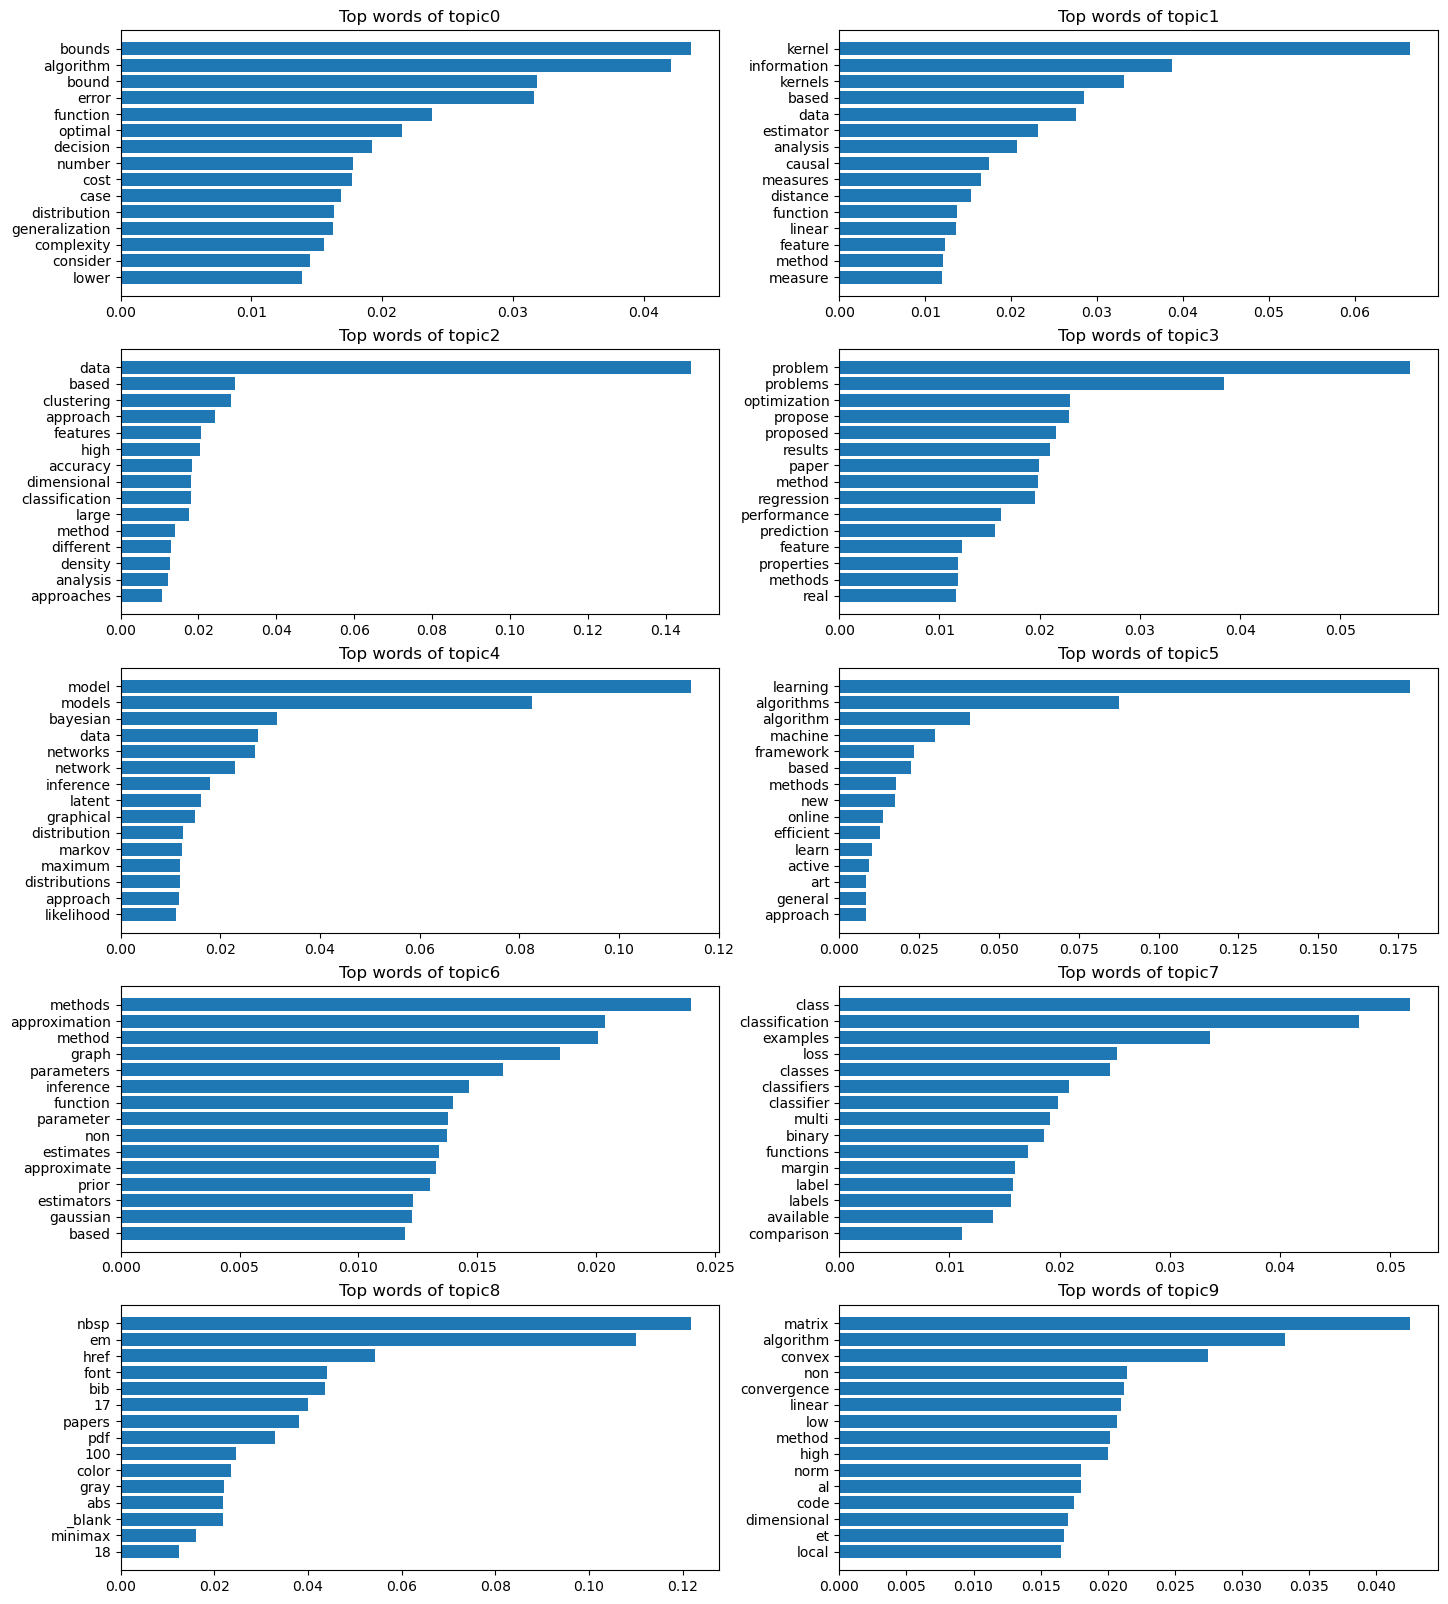

In [346]:
topic = 1
plt.figure(figsize=(17,20)) 
# afficher un subplot pour chaque topic (5*2)
for topic in range(10):
    tops_word , poids = get_top_words_per_topic(B_estimate, vectorizer, topic)
    poids = poids[::-1]
    tops_word = tops_word[::-1]
    plt.subplot(5,2,topic+1)
    plt.barh(tops_word, poids, align='center', alpha=1)
    plt.title('Top words of topic'+str(topic))

- **Remarque :** 
On observe une claire cohésion thématique parmi les mots. Par exemple, le thème 0 est associé à **la théorie du décision**, le thème 3 à **la théorie de l'optimisation**, le thème 7 à **la théorie de la classification**, le thème 5 à **la théorie de machine learning**, et le thème 4 au **réseau de neurones bayésien** ou à **la théorie des graphes.**

- Une observation intéressante est que l'algorithme a réussi à regrouper dans le thème 8 des mots récurrents qui n'ont pas une signification importante et que nous n'avons pas pu supprimer lors de la phase de prétraitement.

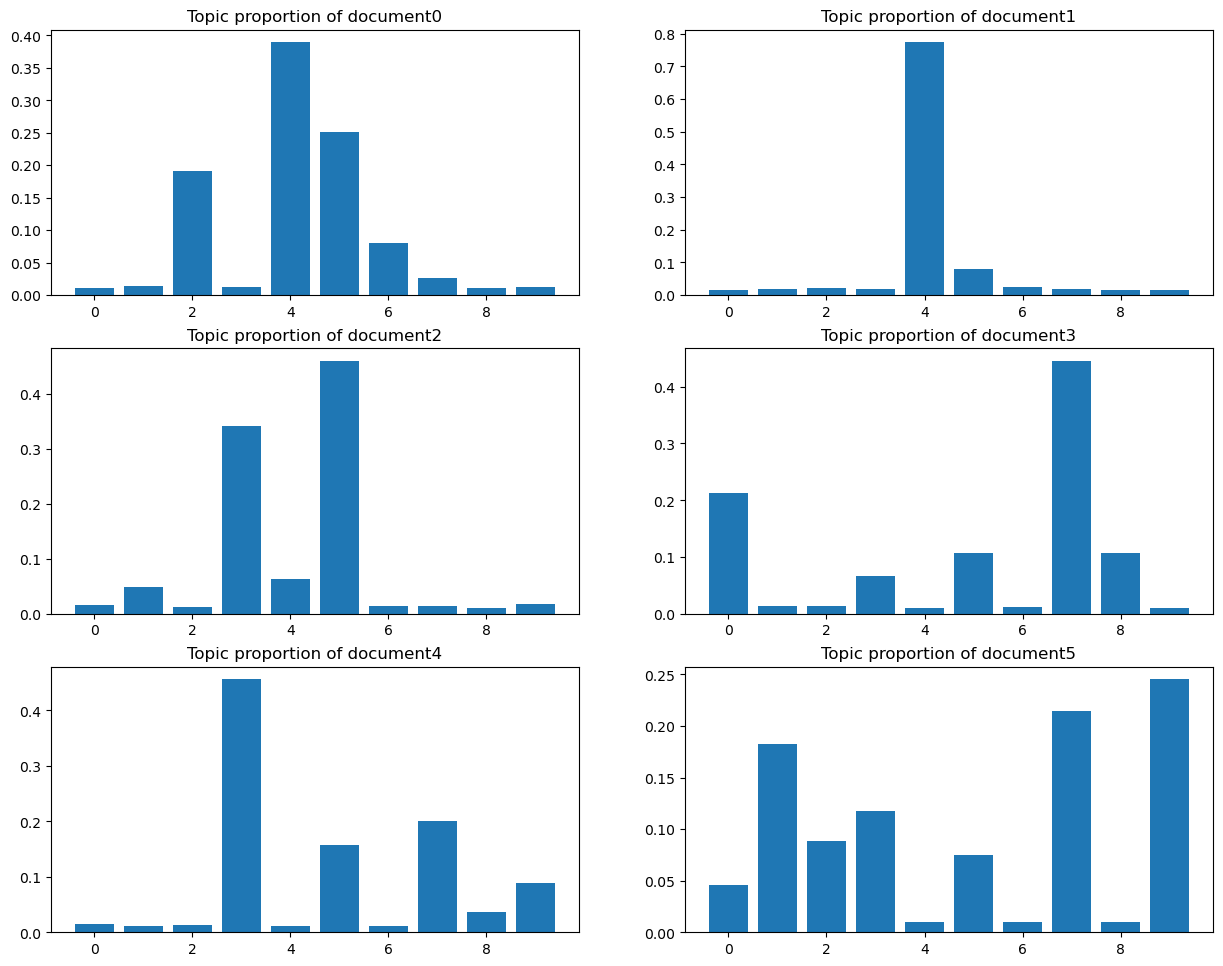

In [342]:
plt.figure(figsize=(15,20))
for document in range(6):
    poids = Gama_estimate[document]
    plt.subplot(5,2,document+1)
    plt.bar(range(10), poids, align='center', alpha=1)
    plt.title('Topic proportion of document'+str(document))
 

In [331]:
print(jmlr_papers[1]["abstract"])

We describe a graphical model for probabilistic relationships--analternative to the Bayesian network--called a dependency network.  Thegraph of a dependency network, unlike a Bayesian network, ispotentially cyclic.  The probability component of a dependencynetwork, like a Bayesian network, is a set of conditionaldistributions, one for each node given its parents.  We identifyseveral basic properties of this representation and describe acomputationally efficient procedure for learning the graph andprobability components from data.  We describe the application of thisrepresentation to probabilistic inference, collaborative filtering(the task of predicting preferences), and the visualization of acausalpredictive relationships.<p>


- **Remarque**: 
Il est observable que le document 1 est principalement lié au thème 4, qui concerne les réseaux de neurones bayésiens. Cela est cohérent avec le titre du document qui est : "We describe a graphical model for probabilistic relationships--analternative to the Bayesian network--called a dependency network".

**Q5.** Open questions :
* What are some limitations of the LDA model ? Can you imagine an improvement ?
- **Réponse :** Le defaut et au meme temps la force de LDA est sa simplicité: les documents sont des mixtures de sujets, les sujets sont des mixtures de mots. Cependant, cette simplicité est aussi une limitation car elle ne permet pas de capturer des relations plus complexes entre les mots et les documents. Des améliorations peut etre apportées en utilisant des modèles plus complexes, par exemple:
1. Modèle LDA associé à un modèle de Markov caché, capturant les dépendances entre les mots voisins.
2. Modèle non paramétrique basé sur le processus de Dirichlet, utilisant un nombre infini de sujets. 
4. Modèle hiérarchique, utilisant une hiérarchie de sujets, allant du plus général au plus concre.
5. Extensions pour tenir compte des métadonnées telles que l'auteur, le titre, l'emplacement, etc.

In this notebook, we have treated the hyperparameters as fixed. How could they be learned ?
- **réponse :**
Les hyperparamètres peuvent être appris en utilisant des méthodes de type EM. Cependant, cela nécessite de calculer la vraisemblance marginale, qui est généralement difficile à calculer.

Can you imagine a method to choose the number of topics ?
- **réponse :** Une méthode est de chercher le nombre de topic qui maximise le ELBO ou bien utiliser un modèle non paramétrique basé sur le processus de Dirichlet, utilisant un nombre infini de sujets. 


What strategies should we use to make the algorithm more efficient ?
- **réponse :** Pour améliorer le LDA, on peut essayer d'explorer l'approximation laplacienne, des techniques variationnelles d'ordre supérieur et essayer les MCMC.

**BONUS.** Papier-crayon. À partir du modèle, pouvez-vous dériver les lois conditionnelles de l'échantillonneur de Gibbs ? Pour rappel, nous avons besoin de ces lois pour dériver ensuite les updates de l'algorithme CAVI.